In this notebook we will explore approaches to our main task - how do we handle multiple destinations and multiple drivers?  

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [30]:
###OSHAWA/WHITBY 
north = 43.944503
west = -78.791660
south = 43.902879
east = -78.854552

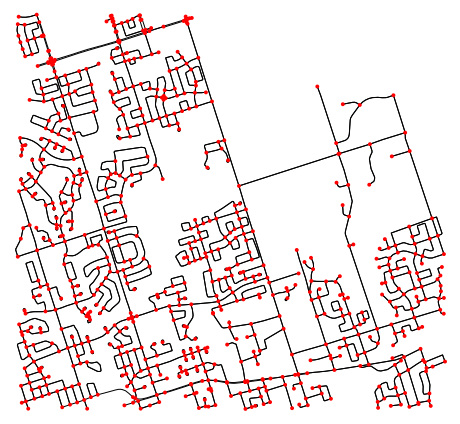

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [31]:
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive') 
# Plotting the map graph 
ox.plot_graph(G, bgcolor='white', edge_color='black', node_color='red')

### Selecting Multiple Destinations

In [4]:
# Picking some random points within the defined graph
dest0 = 43.878838, -78.911281
dest1 = 43.889695, -78.877941
dest2 = 43.896969, -78.892852
dest3 = 43.871507, -78.908451
dest4 = 43.879664, -78.924280
dest5 = 43.892340, -78.949055
dest6 = 43.921381, -78.875564
dest7 = 43.917911, -78.907297
dest8 = 43.870247, -78.944766
dest9 = 43.896866, -78.952642
data = [dest0, dest1, dest2, dest3, dest4, dest5, dest6, dest7, dest8, dest9]

In [5]:
# Create a dataframe for plotting purposes
df = pd.DataFrame(data, columns =['Longitude', 'Latitude'])
df

,Longitude,Latitude
0,43.878838,-78.911281
1,43.889695,-78.877941
2,43.896969,-78.892852
3,43.871507,-78.908451
4,43.879664,-78.924280
5,43.892340,-78.949055
6,43.921381,-78.875564
7,43.917911,-78.907297
8,43.870247,-78.944766
9,43.896866,-78.952642


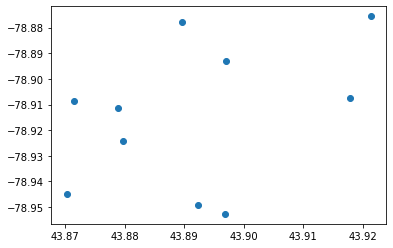

In [6]:
# Plot the locations
plt.scatter(x=df['Longitude'], y=df['Latitude'])
plt.show()

### Use K-Means to Cluster Destinations

Say we have three drivers - we want to group these locations into three clusters.

In [7]:
kmeans = KMeans(n_clusters=3)

In [8]:
# Fit on the data
kmeans.fit(data)

KMeans(n_clusters=3)

In [9]:
# Get the labels
kmeans.labels_

array([2, 0, 0, 2, 2, 1, 0, 0, 1, 1])

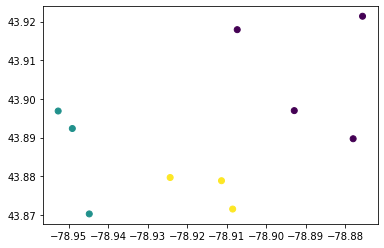

In [10]:
# Plot the locations with their clusters shown
plt.scatter(x=df['Latitude'], y=df['Longitude'], c=kmeans.labels_)

So this gives us a method for grouping locations into clusters, but now how do we find the optimal order to visit each location within a cluster?

In [48]:
df['Cluster'] = kmeans.labels_
df

,Longitude,Latitude,Cluster
0,43.878838,-78.911281,0
1,43.889695,-78.877941,2
2,43.896969,-78.892852,2
3,43.871507,-78.908451,0
4,43.879664,-78.924280,0
5,43.892340,-78.949055,1
6,43.921381,-78.875564,2
7,43.917911,-78.907297,2
8,43.870247,-78.944766,1
9,43.896866,-78.952642,1


Let's just consider cluster 1 for now.

In [60]:
trip = df[df['Cluster']==1]
trip

,Longitude,Latitude,Cluster
5,43.892340,-78.949055,1
8,43.870247,-78.944766,1
9,43.896866,-78.952642,1


In [61]:
# We need to get the graph nodes for these locations
dest5_node = ox.get_nearest_node(G, dest5)
dest8_node = ox.get_nearest_node(G, dest8)
dest9_node = ox.get_nearest_node(G, dest9)

We will look here at just splitting the route into two; from 5 to 8 and then from 8 to 9; finding the optimal paths for each of these legs, and then simply joining them together.

In [73]:
# Get the first leg
step1 = nx.shortest_path(G, dest5_node, dest8_node, weight='lenght')

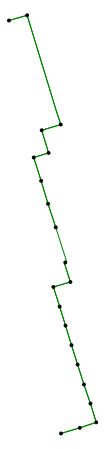

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [74]:
# Plot the route
route_graph = G.subgraph(step1)
ox.plot_graph(route_graph, bgcolor='white', edge_color='green', node_color='black')

In [75]:
# Get the second leg
step2 = nx.shortest_path(G, dest8_node, dest9_node, weight='lenght')

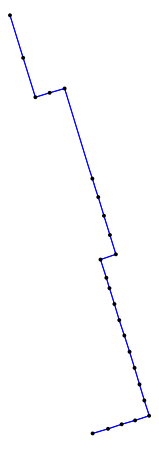

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [76]:
# Plot the route
route_graph2 = G.subgraph(step2)
ox.plot_graph(route_graph2, bgcolor='white', edge_color='blue', node_color='black')

In [77]:
# We want to combine this into one list
route = step1
# Since the first node of step2 is the same as the last node of step1, 
# we do not duplicate it in our list
for step in step2[1:]:
    route.append(step)

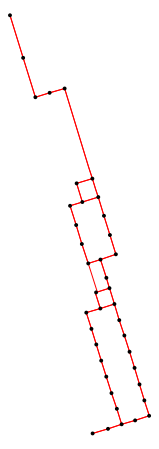

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [78]:
# Plot the full route
route_graph = G.subgraph(route)
ox.plot_graph(route_graph, bgcolor='white', edge_color='red', node_color='black')

In this simple example with three destinations we can simply compute each of the possible orders, and then optimize based on our measure - distance, time, cost, etc.  But here we want a better solution - one that will be more suitable when we have many destinations within our cluster.

#### Travelling Salesman Problem

We will explore AI solutions to the classic travelling salesman problem - how can we optimize our path when we must visit each of a set of locations?

One purposed solution will be to create a new graph of each of our locations.  Then, using the previously described methods, we can generate the optimal path length between each pair of locations.  Next, we use these as edge weights in our graph.  Finally, we search for an ordering that will allow us to visit each of the destination while minimizing the total distance travelled. 

In [79]:
# We need to get the graph nodes for these locations
dest0_node = ox.get_nearest_node(G, dest0)
dest1_node = ox.get_nearest_node(G, dest1)
dest2_node = ox.get_nearest_node(G, dest2)
dest3_node = ox.get_nearest_node(G, dest3)
dest4_node = ox.get_nearest_node(G, dest4)
dest5_node = ox.get_nearest_node(G, dest5)
dest6_node = ox.get_nearest_node(G, dest6)
dest7_node = ox.get_nearest_node(G, dest7)
dest8_node = ox.get_nearest_node(G, dest8)
dest9_node = ox.get_nearest_node(G, dest9)

In [80]:
trip_nodes = [dest0_node, dest1_node, dest2_node, dest3_node, dest4_node, dest5_node,
             dest6_node, dest7_node, dest8_node, dest9_node]

In [81]:
# Pair these nodes to create all of the edges
edges = [(trip_nodes[i],trip_nodes[j]) for i in range(len(trip_nodes)) for j in range(i+1, len(trip_nodes))]
edges

[(392179336, 3819384094),
 (392179336, 392172979),
 (392179336, 3736267507),
 (392179336, 392178224),
 (392179336, 392176039),
 (392179336, 392177008),
 (392179336, 392165428),
 (392179336, 392172134),
 (392179336, 392162488),
 (3819384094, 392172979),
 (3819384094, 3736267507),
 (3819384094, 392178224),
 (3819384094, 392176039),
 (3819384094, 392177008),
 (3819384094, 392165428),
 (3819384094, 392172134),
 (3819384094, 392162488),
 (392172979, 3736267507),
 (392172979, 392178224),
 (392172979, 392176039),
 (392172979, 392177008),
 (392172979, 392165428),
 (392172979, 392172134),
 (392172979, 392162488),
 (3736267507, 392178224),
 (3736267507, 392176039),
 (3736267507, 392177008),
 (3736267507, 392165428),
 (3736267507, 392172134),
 (3736267507, 392162488),
 (392178224, 392176039),
 (392178224, 392177008),
 (392178224, 392165428),
 (392178224, 392172134),
 (392178224, 392162488),
 (392176039, 392177008),
 (392176039, 392165428),
 (392176039, 392172134),
 (392176039, 392162488),
 (39217

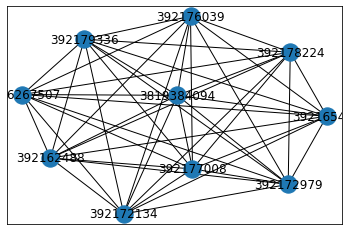

In [82]:
# Create a graph object containing each of these nodes
# Each node is connected to each other node
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()

We can use our database to get the optimal path lenghts between each node pairs, and then set these as the edge weights in this graph.